# Image Classification with TensorFlow

Image classification is a common task for deep learning and neural networks.  The raw features coming in are the pixel values.  These are simple enough to deal with, but it is difficult to connect pixel values to determining whether an image is of a cat.  Older methods used a lot of clever filters, but the current best-of-breed algorithms simply throw a lot of linear algebra at the problem.

In this miniproject, you build a series of models to classify a series of images into one of ten classes. For expediency, these images are pretty small ($32\times32\times3$).  This can make classification a bit tricky&mdash;human performance is only about 94%.  Each of your models will be scored by comparing its accuracy to the accuracy of a reference model that we developed.  A score of 1 indicates that your model performs as well as the reference model; not that your accuracy is 100%!

You will be given both a training set and a validation set.  Ground truth values are provided for the training set.  You should train your models on this set, and then make predictions for each of the validation images.  These predictions will be submitted to the grader.

## A note on scoring

It **is** possible to score above 1 on these questions. This indicates that you've beaten our reference model&mdash;we compare our model's score on a test set to your score on a test set. See how high you can go!

## Downloading the data

We will be using the `CIFAR-10` data set.  It consists of 60,000 images, each $32\times32$ color pixels, each belonging to one of ten classes.  The following cell will download the data, in NumPy's `.npy` format.

We can load in the data like so:

In [4]:
import numpy as np
import gzip

train_images = np.load(gzip.open('train_images.npy.gz', 'rb'))
train_labels = np.load(gzip.open('train_labels.npy.gz', 'rb'))
validation_images = np.load(gzip.open('validation_images.npy.gz', 'rb'))

The images are stored as four-dimensional arrays.  The first index indicates the image number, the second and third the $x$ and $y$ positions, and the fourth index the color channel.  Each pixel color is a floating point number between 0 and 1.  This convention allows us to view the images with matplotlib:

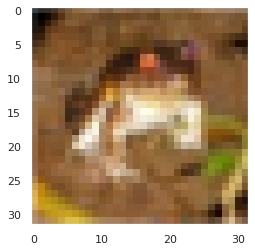

In [5]:
import matplotlib.pyplot
matplotlib.pyplot.rcParams["axes.grid"] = False  #  Remove the grid lines from the image.
matplotlib.pyplot.imshow(train_images[0])

The classes have already been numbered 0-9 for us; those numbers are stored in the vector `train_labels`.

In [6]:
train_labels[0]

6

The human-readable names associated with this classes are

In [7]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [8]:
label_names[train_labels[0]]

'frog'

So we can see that the image above is a frog.  (Now you see it!)

# Questions

## Perceptual Delta

Since we already have a number of labeled images, a simple approach would be to measure the difference between two images, and choose the label corresponding to nearby images.  To do this, we need to develop a metric to determine the distance between two images.  We'll make the simplifying (and completely wrong) assumption that this is just the average difference between the colors of the corresponding pixels in the two images.

While we could just take RMS difference of the red, green, and blue pixels, let's be slightly more sophisticated and look at human vision for a metric.  After all, we're pretty good at image classifications, so there might be some useful optimization here.

It turns out that modeling human perception is [extraordinarily complicated](https://en.wikipedia.org/wiki/Color_difference#CIEDE2000).  We're going to use a [simplified model](https://www.compuphase.com/cmetric.htm):

$$\Delta C \equiv \sqrt{2 \Delta R^2 + 4 \Delta G^2 + 3 \Delta B^2 + \bar R\left(\Delta R^2 - \Delta B^2 \right)} $$
where $(R_1, G_1, B_1)$ and $(R_2, G_2, B_2)$ are the RGB components of the two colors and
$$\begin{align}
\Delta R &= R_1 - R_2 \\
\Delta G &= G_1 - G_2 \\
\Delta B &= B_1 - B_2 \\
\bar R &= \textstyle\frac{1}{2}\left(R_1 + R_2\right)
\end{align}$$

This accounts for the fact that our eyes are most sensitive to green and least sensitive to red, and that perception is not constant with hue.

Build a graph that takes in a series of images, as well as a base image, and returns a result containing the $\Delta C$ value (for each pixel) between the base image and each image in the series.  

(Note that the intention here in our solution is that `images` will be a stack of images, while `base` is a single image.  Since the function is decorated with `tf.function` the computations within the function will be recorded in a computation graph and the output from this function will be a tensor.)

In [9]:
import tensorflow as tf

@tf.function
def delta_func(images, base):
    dr = images[:, :, :, 0] - base[:, :, 0]
    dg = images[:, :, :, 1] - base[:, :, 1]
    db = images[:, :, :, 2] - base[:, :, 2]
    rmean = (images[:, :, :, 0] + base[:, :, 0])/2

    deltaC = (2*(dr**2) + 4*(dg**2) + 3*(db**2) + rmean*((dr**2) - (db**2)))**.5
    return deltaC

As stated, for two images, $I_1$ and $I_2$, we define the distance between $I_1$ and $I_2$ as the average $\Delta C$ value over the whole image, that is:

$$d(I_1, I_2) = \frac{1}{N}\sum_{p_j} \Delta C(p_j)$$
where the sum is over all pixels $p_j$, $\Delta C(p_2)$ is the $\Delta C$ value for the pixel $p_j$, and $N$ is the total number of pixels in each image ($N= 32\times 32$ in our case).

Using `delta_func` compute the distance between the first validation image and all of the training images.

**Checkpoint:** The mean value of the distances is 1.159, and the standard deviation of the distances is 0.182.

In [10]:
deltas = delta_func(train_images, validation_images[0])

2022-03-03 20:01:07.393025: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.
2022-03-03 20:01:07.760081: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


In [11]:
distances = []

for i in range(50000):
    distances.append(np.mean(deltas[i]))

From these, find the 100 closest images from the training set to this first validation image.  (Note that `numpy.argsort` might help here.)  Submit a list of the indices of these images to the grader.

In [12]:
indices = np.argsort(np.array(distances))[:100]
indices[:10]

array([27912, 23437, 47732, 25053, 29251,  3616, 43445,  5555, 46911,
       16269])

In [13]:
# indices = [43234]*100

grader.score('tf__perceptual_delta', indices)

Your score: 1.0000


**Extension:** What does this suggest about the proper class for this image?

> **Aside:** Essentially, we've started to implement a $k$-nearest neighbors algorithm, using this perceptual distance as our metric.  If we ran the difference between all of the validation images and each of the training images, we could make a prediction from the nearest images for each.  Give it a try, if you're interested, but this miniproject is going to go in another direction.

## Softmax model

...

## Fully-connected model

Now, add a hidden layer to this network.  Train this network on the pixel values, and once again use it to predict the most likely class for each of the validation images.

**Hints:**
- We found that adding more layers didn't help too much.
- Watch out for overfitting.  Dropout can help with this.
- The reference solution achieves an accuracy of about 44% on a training set and 41% on a test set.

In [18]:
from tensorflow import keras

In [19]:
X_train = [np.concatenate(np.concatenate(im)) for im in train_images]

In [20]:
y_train = train_labels[:49000]

X_t = np.asarray(X_train[:49000])

X_test = np.asarray(X_train[49000:])
y_test = train_labels[49000:]
                          
from tensorflow.keras.utils import to_categorical as one_hot

y_train_hot = one_hot(y_train)
y_test_hot = one_hot(y_test)
                          

N_PIXELS= 32 * 32 * 3
N_CLASSES = 10

hidden_size = 64

In [21]:
model = keras.models.Sequential()

model.add(
    keras.layers.Dense(
        hidden_size,
        activation='sigmoid',
        use_bias=True,  # The default
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=N_PIXELS**-0.5)
    )
)

model.add(
    keras.layers.Dense(
        10,
        activation='softmax',
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=hidden_size**-0.5)
    )
)


model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.5),
              metrics=['accuracy'])

In [22]:
history = model.fit(X_t, y_train_hot,
                    epochs=30,
                    batch_size=128,
                    validation_data=(X_test,y_test_hot))

Epoch 1/30
383/383 [==============================] - 2s 4ms/step - loss: 1.9731 - accuracy: 0.2835 - val_loss: 1.9252 - val_accuracy: 0.3230
Epoch 2/30
383/383 [==============================] - 1s 3ms/step - loss: 1.7962 - accuracy: 0.3583 - val_loss: 1.7564 - val_accuracy: 0.3900
Epoch 3/30
383/383 [==============================] - 1s 3ms/step - loss: 1.7234 - accuracy: 0.3835 - val_loss: 1.7241 - val_accuracy: 0.3900
Epoch 4/30
383/383 [==============================] - 1s 3ms/step - loss: 1.6716 - accuracy: 0.4055 - val_loss: 1.6895 - val_accuracy: 0.3940
Epoch 5/30
383/383 [==============================] - 1s 3ms/step - loss: 1.6258 - accuracy: 0.4193 - val_loss: 1.6519 - val_accuracy: 0.4120
Epoch 6/30
383/383 [==============================] - 1s 3ms/step - loss: 1.5993 - accuracy: 0.4313 - val_loss: 1.6315 - val_accuracy: 0.4180
Epoch 7/30
383/383 [==============================] - 1s 3ms/step - loss: 1.5732 - accuracy: 0.4397 - val_loss: 1.6308 - val_accuracy: 0.4130
Epoch 

In [23]:
val = [np.concatenate(np.concatenate(im)) for im in validation_images]

In [24]:
predicted_classes = list(np.argmax(model.predict(np.asarray(val)),axis=1))

In [25]:
# predicted_classes = [0]*len(validation_images)

grader.score('tf__fully_connected', predicted_classes)

Your score: 1.2768


## Convolutional model

...

## Transfer learning

...

*Copyright &copy; 2022 Pragmatic Institute. This content is licensed solely for personal use. Redistribution or publication of this material in whole is strictly prohibited.*